# Starter for Bayesian Neural Networks using Pyro
#### Pyro and Pytorch will be used.
#### A familiarity with Pytorch would help understanding concepts easier.
#### The following example is adapted from [McElreath, D., Statistical Rethinking, Chapter 7, 2016]. We would like to explore the relationship between topographic heterogeneity of a nation as measured by the Terrain Ruggedness Index (variable rugged in the dataset) and its GDP per capita. In particular, it was noted by the authors in (https://diegopuga.org/papers/rugged.pdf) that terrain ruggedness or bad geography is related to poorer economic performance outside of Africa, but rugged terrains have had a reverse effect on income for African nations.
## Content of this notebook:
* Regression using Pyro with sample data
* Bayesian Regression using Pyro with sample data
* Classification using Pyro with collision avoidance data
* Bayesian Classification using Pyro with collision avoidance data

## 1. Regression using Pyro with sample data

In [109]:
%reset -s -f

In [37]:
# Libraries
import os
from functools import partial
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro
import pyro.distributions as dist

# Set matplotlib settings
%matplotlib inline
plt.style.use('default')

In [111]:
# Data
DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]
df = df[np.isfinite(df.rgdppc_2000)]

<AxesSubplot:>

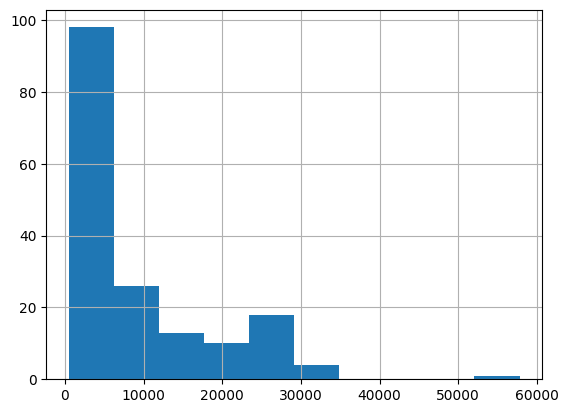

In [112]:
df['rgdppc_2000'].hist()

In [113]:
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])

#### The response variable GDP is highly skewed, so we will log-transform it

<AxesSubplot:>

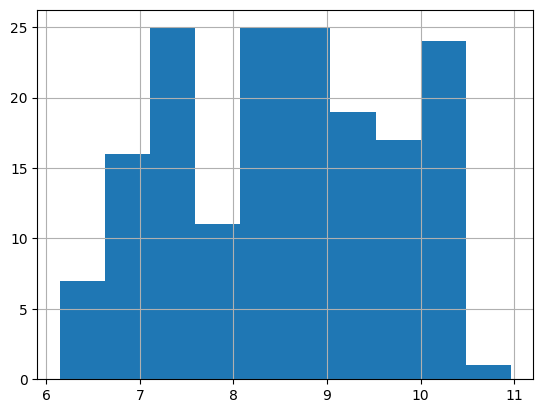

In [114]:
df['rgdppc_2000'].hist()

/home/rabay/anaconda3/envs/bayesian_nn/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/rabay/anaconda3/envs/bayesian_nn/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


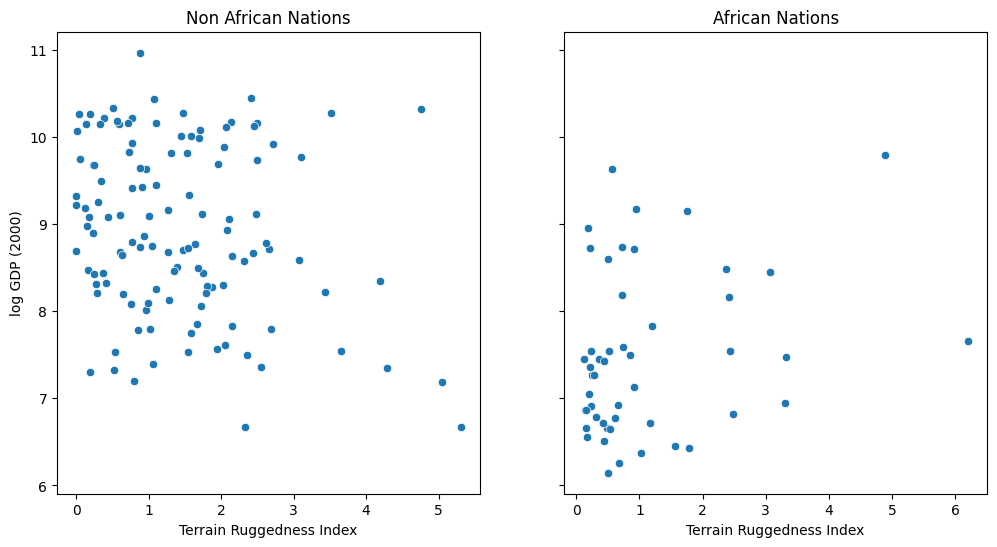

In [115]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = df[df["cont_africa"] == 1]
non_african_nations = df[df["cont_africa"] == 0]
sns.scatterplot(non_african_nations["rugged"],
            non_african_nations["rgdppc_2000"],
            ax=ax[0])
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
sns.scatterplot(african_nations["rugged"],
                african_nations["rgdppc_2000"],
                ax=ax[1])
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

In [116]:
df.head()

cont_africa  rugged  rgdppc_2000
2            1   0.858     7.492609
4            0   3.427     8.216929
7            0   0.769     9.933263
8            0   0.775     9.407032
9            0   2.688     7.792343

#### We would like to predict log GDP per capita of a nation as a function of two features from the dataset - whether the nation is in Africa, and its Terrain Ruggedness Index. 

In [117]:
from torch import nn
from pyro.nn import PyroModule

assert issubclass(PyroModule[nn.Linear], nn.Linear)
assert issubclass(PyroModule[nn.Linear], PyroModule)

In [118]:
# Dataset: Add a feature to capture the interaction between "cont_africa" and "rugged"
df["cont_africa_x_rugged"] = df["cont_africa"] * df["rugged"]
data = torch.tensor(df[["cont_africa", "rugged", "cont_africa_x_rugged", "rgdppc_2000"]].values,
                        dtype=torch.float)
x_data, y_data = data[:, :-1], data[:, -1]

In [119]:
# Model
# Regression model
linear_reg_model = PyroModule[nn.Linear](3, 1)

In [120]:
# Define loss and optimize
loss_fn = torch.nn.MSELoss(reduction='sum')
optim = torch.optim.Adam(linear_reg_model.parameters(), lr=0.05)

In [121]:
# train function
def train():
    # run the model forward on the data
    y_pred = linear_reg_model(x_data).squeeze(-1)
    # calculate the mse loss
    loss = loss_fn(y_pred, y_data)
    # initialize gradients to zero
    optim.zero_grad()
    # backpropagate
    loss.backward()
    # take a gradient step
    optim.step()
    return loss

In [122]:
# train model
num_iterations = 5000
for j in range(num_iterations):
    loss = train()
    if (j + 1) % 50 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss.item()))

[iteration 0050] loss: 3074.2080
[iteration 0100] loss: 1536.9496
[iteration 0150] loss: 1043.8076
[iteration 0200] loss: 775.0713
[iteration 0250] loss: 586.5903
[iteration 0300] loss: 445.4243
[iteration 0350] loss: 342.1983
[iteration 0400] loss: 270.0266
[iteration 0450] loss: 221.8161
[iteration 0500] loss: 190.9913
[iteration 0550] loss: 172.0990
[iteration 0600] loss: 160.9889
[iteration 0650] loss: 154.7156
[iteration 0700] loss: 151.3135
[iteration 0750] loss: 149.5410
[iteration 0800] loss: 148.6539
[iteration 0850] loss: 148.2273
[iteration 0900] loss: 148.0304
[iteration 0950] loss: 147.9431
[iteration 1000] loss: 147.9060
[iteration 1050] loss: 147.8908
[iteration 1100] loss: 147.8849
[iteration 1150] loss: 147.8827
[iteration 1200] loss: 147.8819
[iteration 1250] loss: 147.8817
[iteration 1300] loss: 147.8816
[iteration 1350] loss: 147.8815
[iteration 1400] loss: 147.8815
[iteration 1450] loss: 147.8815
[iteration 1500] loss: 147.8815
[iteration 1550] loss: 147.8815
[iter

In [123]:
# Inspect learned parameters
print("Learned parameters:")
for name, param in linear_reg_model.named_parameters():
    print(name, param.data.numpy())

Learned parameters:
weight [[-1.9480444  -0.2028555   0.39339215]]
bias [9.223223]


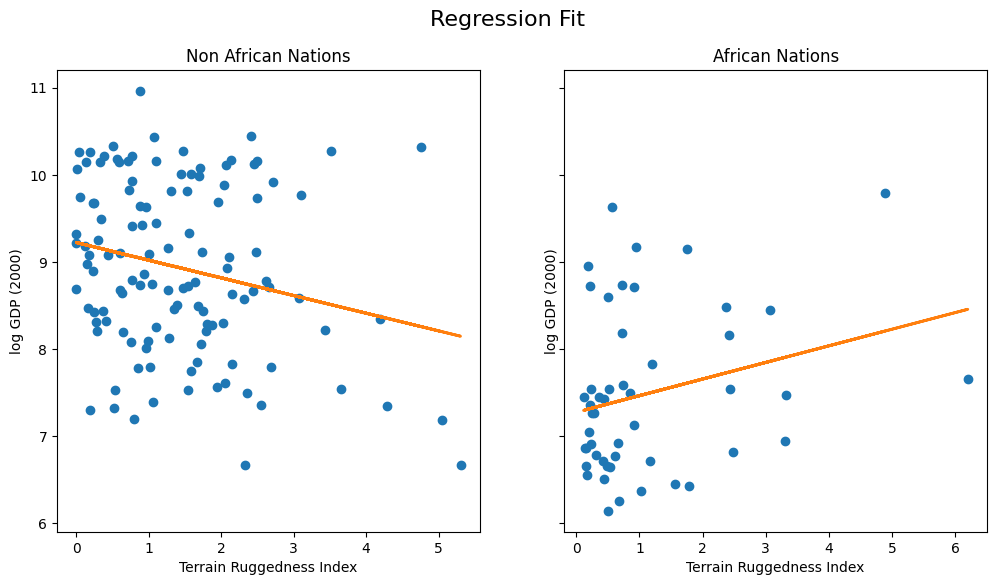

In [124]:
fit = df.copy()
fit["mean"] = linear_reg_model(x_data).detach().cpu().numpy()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = fit[fit["cont_africa"] == 1]
non_african_nations = fit[fit["cont_africa"] == 0]
fig.suptitle("Regression Fit", fontsize=16)
ax[0].plot(non_african_nations["rugged"], non_african_nations["rgdppc_2000"], "o")
ax[0].plot(non_african_nations["rugged"], non_african_nations["mean"], linewidth=2)
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
ax[1].plot(african_nations["rugged"], african_nations["rgdppc_2000"], "o")
ax[1].plot(african_nations["rugged"], african_nations["mean"], linewidth=2)
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

In [125]:
fit.head()

cont_africa  rugged  rgdppc_2000  cont_africa_x_rugged      mean
2            1   0.858     7.492609                 0.858  7.438659
4            0   3.427     8.216929                 0.000  8.528037
7            0   0.769     9.933263                 0.000  9.067226
8            0   0.775     9.407032                 0.000  9.066010
9            0   2.688     7.792343                 0.000  8.677947

#### We notice that the relationship between terrain ruggedness has an inverse relationship with GDP for non-African nations, but it positively affects the GDP for African nations. It is however unclear how robust this trend is. In particular, we would like to understand how the regression fit would vary due to parameter uncertainty. To address this, we will build a simple bayesian model for linear regression. Bayesian modeling offers a systematic framework for reasoning about model uncertainty. Instead of just learning point estimates, we’re going to learn a distribution over parameters that are consistent with the observed data.

## 2. Bayesian Regression using Pyro with sample data

#### In order to make our linear regression Bayesian, we need to put priors on the parameters w and b. These are distributions that represent our prior belief about reasonable values for w and b (before observing any data).

* weights and biases will be defined by PyroSample

In [126]:
from pyro.nn import PyroSample


class BayesianRegression(PyroModule):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = PyroModule[nn.Linear](in_features, out_features)
        self.linear.weight = PyroSample(dist.Normal(0., 1.).expand([out_features, in_features]).to_event(2))
        self.linear.bias = PyroSample(dist.Normal(0., 10.).expand([out_features]).to_event(1))

    def forward(self, x, y=None):
        sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
        mean = self.linear(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean

#### In order to do inference, i.e. learn the posterior distribution over our unobserved parameters, we will use Stochastic Variational Inference (SVI). The guide determines a family of distributions, and SVI aims to find an approximate posterior distribution from this family that has the lowest KL divergence from the true posterior.

In [127]:
from pyro.infer.autoguide import AutoDiagonalNormal

model = BayesianRegression(3, 1)
guide = AutoDiagonalNormal(model)

#### To begin with, we will use the AutoDiagonalNormal guide that models the distribution of unobserved parameters in the model as a Gaussian with diagonal covariance, i.e. it assumes that there is no correlation amongst the latent variables (Note that this is a strong modeling assumption).

#### Under the hood, this defines a guide that uses a Normal distribution with learnable parameters corresponding to each sample statement in the model. e.g. in our case, this distribution should have a size of (5,) correspoding to the 3 regression coefficients for each of the terms, and 1 component contributed each by the intercept term and sigma in the model.

#### Now, We will use stochastic variational inference (SVI)  for doing inference. Just like in the non-Bayesian linear regression model, each iteration of our training loop will take a gradient step, with the difference that in this case, we’ll use the Evidence Lower Bound (ELBO) objective instead of the MSE loss by constructing a Trace_ELBO object that we pass to SVI.

In [128]:
from pyro.infer import SVI, Trace_ELBO


adam = pyro.optim.Adam({"lr": 0.03})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

#### you will notice that we do not need to pass in learnable parameters to the optimizer since that is determined by the guide code and happens behind the scenes within the SVI class automatically. To take an ELBO gradient step we simply call the step method of SVI.

In [129]:
pyro.clear_param_store()
for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(x_data, y_data)
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(data)))

[iteration 0001] loss: 3.3711
[iteration 0101] loss: 2.1950
[iteration 0201] loss: 1.5422
[iteration 0301] loss: 1.4646
[iteration 0401] loss: 1.4812
[iteration 0501] loss: 1.4669
[iteration 0601] loss: 1.4665
[iteration 0701] loss: 1.4582
[iteration 0801] loss: 1.4718
[iteration 0901] loss: 1.4578
[iteration 1001] loss: 1.4609
[iteration 1101] loss: 1.4537
[iteration 1201] loss: 1.4624
[iteration 1301] loss: 1.4745
[iteration 1401] loss: 1.4641
[iteration 1501] loss: 1.4604
[iteration 1601] loss: 1.4630
[iteration 1701] loss: 1.4667
[iteration 1801] loss: 1.4576
[iteration 1901] loss: 1.4698
[iteration 2001] loss: 1.4666
[iteration 2101] loss: 1.4627
[iteration 2201] loss: 1.4590
[iteration 2301] loss: 1.4593
[iteration 2401] loss: 1.4561
[iteration 2501] loss: 1.4816
[iteration 2601] loss: 1.4598
[iteration 2701] loss: 1.4742
[iteration 2801] loss: 1.4572
[iteration 2901] loss: 1.4547
[iteration 3001] loss: 1.4881
[iteration 3101] loss: 1.4709
[iteration 3201] loss: 1.4945
[iteration

In [130]:
guide.requires_grad_(False)

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

AutoDiagonalNormal.loc Parameter containing:
tensor([-2.3114, -1.8324, -0.2037,  0.3085,  9.1537])
AutoDiagonalNormal.scale tensor([0.0597, 0.1256, 0.0473, 0.0808, 0.0803])


#### To look at the distribution of the latent parameters more clearly, we can make use of the AutoDiagonalNormal.quantiles method which will unpack the latent samples from the autoguide, and automatically constrain them to the site’s support (e.g. the variable sigma must lie in (0, 10)). We see that the median values for the parameters are quite close to the Maximum Likelihood point estimates we obtained from our first model.

In [131]:
guide.quantiles([0.25, 0.5, 0.75])

{'sigma': [tensor(0.8694), tensor(0.9019), tensor(0.9354)],
 'linear.weight': [tensor([[-1.9170, -0.2356,  0.2540]]),
  tensor([[-1.8324, -0.2037,  0.3085]]),
  tensor([[-1.7477, -0.1718,  0.3630]])],
 'linear.bias': [tensor([9.0995]), tensor([9.1537]), tensor([9.2079])]}

#### To evaluate our model, we’ll generate some predictive samples and look at the posteriors. 
#### Note that in return_sites, we specify both the outcome ("obs" site) as well as the return value of the model ("_RETURN") which captures the regression line. Additionally, we would also like to capture the regression coefficients (given by "linear.weight") for further analysis.
#### The remaining code is simply used to plot the 90% CI for the two variables from our model.

In [132]:
from pyro.infer import Predictive


def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats


predictive = Predictive(model, guide=guide, num_samples=800,
                        return_sites=("linear.weight", "obs", "_RETURN"))
samples = predictive(x_data)
pred_summary = summary(samples)

In [133]:
mu = pred_summary["_RETURN"]
y = pred_summary["obs"]
predictions = pd.DataFrame({
    "cont_africa": x_data[:, 0],
    "rugged": x_data[:, 1],
    "mu_mean": mu["mean"],
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
    "y_mean": y["mean"],
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "true_gdp": y_data,
})

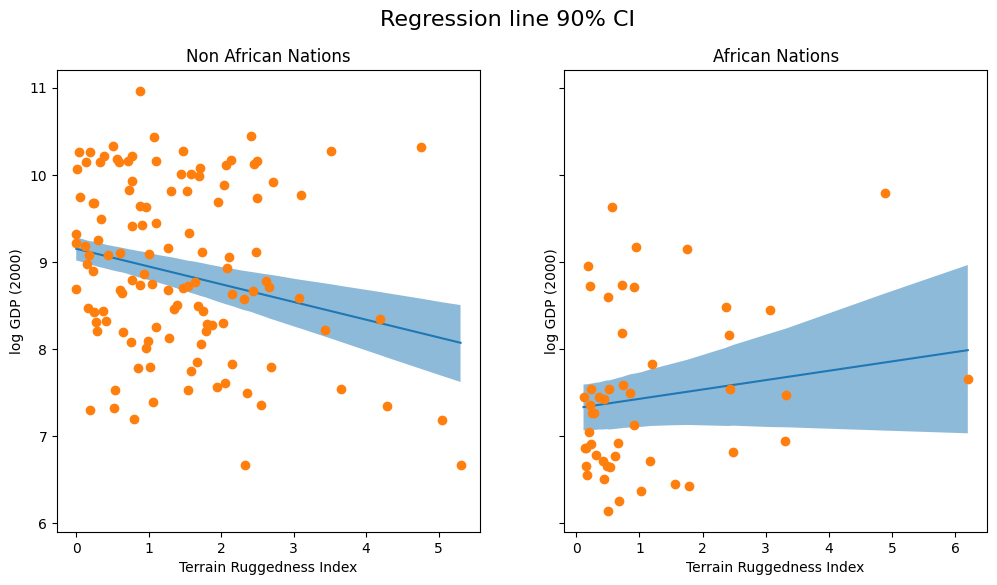

In [134]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = predictions[predictions["cont_africa"] == 1]
non_african_nations = predictions[predictions["cont_africa"] == 0]
african_nations = african_nations.sort_values(by=["rugged"])
non_african_nations = non_african_nations.sort_values(by=["rugged"])
fig.suptitle("Regression line 90% CI", fontsize=16)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["mu_mean"])
ax[0].fill_between(non_african_nations["rugged"],
                   non_african_nations["mu_perc_5"],
                   non_african_nations["mu_perc_95"],
                   alpha=0.5)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["true_gdp"],
           "o")
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
idx = np.argsort(african_nations["rugged"])
ax[1].plot(african_nations["rugged"],
           african_nations["mu_mean"])
ax[1].fill_between(african_nations["rugged"],
                   african_nations["mu_perc_5"],
                   african_nations["mu_perc_95"],
                   alpha=0.5)
ax[1].plot(african_nations["rugged"],
           african_nations["true_gdp"],
           "o")
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

## 3. Classification using Pyro with collision avoidance data

In [131]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from torch import nn
from pyro.nn import PyroModule
from sklearn.metrics import confusion_matrix as cm

assert issubclass(PyroModule[nn.Linear], nn.Linear)
assert issubclass(PyroModule[nn.Linear], PyroModule)
pd.set_option('display.max_rows', None)

In [3]:
# Prepare the data to test challenge metric
# Define paths
path_to_dataset = './data/'
# Read the training data
train = pd.read_csv(os.path.join(path_to_dataset,'train_data.csv'))
test = pd.read_csv(os.path.join(path_to_dataset,'test_data.csv'))
# Shapes of the train and test dataset
print("shape of train data {}".format(train.shape))
print("shape of test data {}".format(test.shape))

shape of train data (162634, 103)
shape of test data (24484, 103)


In [4]:
# Train time to close approach (TCA) min and max
train["time_to_tca"].describe().loc[["min","max"]]

min   -0.149808
max    6.993832
Name: time_to_tca, dtype: float64

In [5]:
# Train time to close approach min and max
test["time_to_tca"].describe().loc[["min","max"]]

min    2.000213
max    6.993169
Name: time_to_tca, dtype: float64

In [6]:
# Shows how many events exist in the datasets
print("number of events that has less than 1.0 days data : ",len(train[train["time_to_tca"]<1.0].groupby("event_id").count()["time_to_tca"].tolist()))
print("number of events that has more than 2.0 days data : ",len(train[train["time_to_tca"]>2.0].groupby("event_id").count()["time_to_tca"].tolist()))
print("total number of events : ",len(train.groupby("event_id").count()["time_to_tca"].tolist()))
events_less_than_two_days = train[train["time_to_tca"]<1.0].groupby("event_id")["event_id"].first().tolist()
events_more_than_two_days = train[train["time_to_tca"]>2.0].groupby("event_id")["event_id"].first().tolist()

number of events that has less than 1.0 days data :  9463
number of events that has more than 2.0 days data :  11942
total number of events :  13154


In [7]:
# Number of events that has time_to_tca larger and smaller than 2 at the same time
events_trainable = [value for value in events_less_than_two_days if value in events_more_than_two_days]
print("number of trainable events : ",len(events_trainable))

number of trainable events :  8293


In [8]:
# Shows an event
train[train['event_id']==events_trainable[2]]

event_id  time_to_tca  mission_id       risk  max_risk_estimate  \
50         4     4.966244          19  -7.870632          -6.800245   
51         4     4.030424          19  -7.968592          -6.807711   
52         4     3.066467          19 -30.000000          -7.661743   
53         4     1.797727          19 -30.000000          -8.792366   
54         4     1.528456          19 -30.000000          -8.795880   
55         4     1.258629          19 -30.000000          -8.763967   
56         4     0.973420          19 -30.000000          -8.759451   
57         4     0.592587          19 -30.000000          -8.764977   
58         4     0.273166          19 -27.650917          -7.819587   

    max_risk_scaling  miss_distance  relative_speed  relative_position_r  \
50          5.111282        31612.0         12093.0                182.4   
51          5.363402        33272.0         12093.0                178.7   
52        434.669432        33593.0         12093.0                163.6   
53       4334.538505        23709.0         12093.0                188.2   
54       4380.345259        23700.0         12093.0                187.7   
55       4022.819178        23099.0         12093.0                182.4   
56       4008.467679        23059.0         12093.0                186.3   
57       4053.221837        23066.0         12093.0                187.1   
58         50.584357        23080.0         12093.0                187.1   

    relative_position_t  ...  t_sigma_rdot  c_sigma_rdot  t_sigma_tdot  \
50             -18561.7  ...      0.315782     23.566497      0.008778   
51             -19540.0  ...      0.216134     22.984521      0.007798   
52             -19727.8  ...      0.081852      2.058484      0.007439   
53             -13921.3  ...      0.049963      1.671888      0.005886   
54             -13915.3  ...      0.038328      1.671888      0.005448   
55             -13563.3  ...      0.038758      1.683556      0.005448   
56             -13540.0  ...      0.037867      1.683555      0.005102   
57             -13545.2  ...      0.023785      1.683555      0.004298   
58             -13552.1  ...      0.024574      4.373659      0.004242   

    c_sigma_tdot  t_sigma_ndot  c_sigma_ndot   F10   F3M   SSN    AP  
50      0.062139      0.005695      0.078138  87.0  86.0  29.0  20.0  
51      0.061950      0.005318      0.078065  85.0  86.0  26.0  35.0  
52      0.054042      0.005327      0.076470  84.0  86.0  30.0  36.0  
53      0.331101      0.005107      0.303638  82.0  86.0  17.0  36.0  
54      0.331101      0.005037      0.303638  82.0  86.0  17.0  36.0  
55      0.331079      0.005038      0.303620  80.0  86.0  12.0  20.0  
56      0.331080      0.007247      0.303619  80.0  86.0  12.0  20.0  
57      0.331080      0.006655      0.303619  80.0  86.0  12.0  20.0  
58      0.331474      0.006524      0.303632  81.0  86.0   0.0  17.0  

[9 rows x 103 columns]

In [9]:
# Generates new training data that uses last available CDM (until 2 days to tca) and \
# adds latest CDM risk as target variable
lenData = len(events_trainable)
new_train = []
target_variable = []
no_larger_2 = []
mean_larger_2 =[]
std_larger_2 = []
mean_nan_number =[]
std_nan_number = []
for cnt in range(lenData):
    new_train.append(train[(train["event_id"]==events_trainable[cnt])&(train["time_to_tca"]>=2.0)][-1:].values.tolist()[0])
    target_variable.append(train[(train["event_id"]==events_trainable[cnt])][-1:].risk.values[0])
    no_larger_2.append(train[(train["event_id"]==events_trainable[cnt])&(train["time_to_tca"]>=2.0)].shape[0])
    mean_larger_2.append(train[(train["event_id"]==events_trainable[cnt])&(train["time_to_tca"]>=2.0)].risk.mean())
    std_larger_2.append(train[(train["event_id"]==events_trainable[cnt])&(train["time_to_tca"]>=2.0)].risk.std(ddof=0))
    mean_nan_number.append(train[(train["event_id"]==events_trainable[cnt])&(train["time_to_tca"]>=2.0)].isnull().sum(axis=1).mean())
    std_nan_number.append(train[(train["event_id"]==events_trainable[cnt])&(train["time_to_tca"]>=2.0)].isnull().sum(axis=1).std(ddof=0))
new_traintrain_pd = pd.DataFrame(new_train,columns=train.columns.tolist())
# Adds target value to the dataset
target_variable_pd = pd.DataFrame(target_variable,columns=["target_risk"])
no_larger_2_pd = pd.DataFrame(no_larger_2,columns=["no_larger_2"])
mean_larger_2_pd = pd.DataFrame(mean_larger_2,columns=["mean_larger_2"])
std_larger_2_pd = pd.DataFrame(std_larger_2,columns=["std_larger_2"])
mean_nan_number_pd = pd.DataFrame(mean_nan_number,columns=["mean_nan_number"])
std_nan_number_pd = pd.DataFrame(std_nan_number,columns=["std_nan_number"])
new_traintrain_pd["target_risk"] = target_variable_pd.values
new_traintrain_pd["no_larger_2"] = no_larger_2_pd.values
new_traintrain_pd["mean_larger_2"] = mean_larger_2_pd.values
new_traintrain_pd["std_larger_2"] = std_larger_2_pd.values
new_traintrain_pd["mean_nan_number"] = mean_nan_number_pd.values
new_traintrain_pd["std_nan_number"] = std_nan_number_pd.values
new_traintrain_pd.head(20)

event_id  time_to_tca  mission_id       risk  max_risk_estimate  \
0          2     2.340627           2 -30.000000          -6.266241   
1          3     2.278941          19 -30.000000          -7.320481   
2          4     3.066467          19 -30.000000          -7.661743   
3          5     2.103772           5 -13.100070          -4.878440   
4          6     2.040187           1 -30.000000          -5.079355   
5          7     2.531723          15 -30.000000          -7.270268   
6          8     2.285275           4 -18.845576          -6.102813   
7          9     2.033839          19 -14.593460          -7.052125   
8         10     2.131981           7 -30.000000          -6.710411   
9         12     2.225275           5 -15.532096          -6.031657   
10        13     2.164909           5 -30.000000          -6.327071   
11        14     2.022985          19 -30.000000          -8.410162   
12        15     2.488965          15 -28.211832          -6.019769   
13        16     2.142430           1  -5.633390          -5.614394   
14        17     2.059816           1 -30.000000          -4.257118   
15        19     2.453022           7 -30.000000          -6.642065   
16        20     2.117526           2  -9.853872          -5.052272   
17        21     2.041105           3 -30.000000          -5.145512   
18        22     2.218107           6 -30.000000          -7.308123   
19        27     2.367779           1 -30.000000          -4.923724   

    max_risk_scaling  miss_distance  relative_speed  relative_position_r  \
0       4.014425e+02        18763.0         14347.0               -692.9   
1       1.400012e+02        23900.0         13574.0                 26.3   
2       4.346694e+02        33593.0         12093.0                163.6   
3       2.306854e+01          304.0          2001.0                -13.8   
4       5.542897e+02        10864.0         10027.0                139.5   
5       5.825374e+02        27554.0         12410.0               -708.3   
6       3.386281e+01         4598.0         12218.0                340.3   
7       2.142250e+01        29864.0         14072.0                 81.8   
8       6.675301e+03        35814.0         10813.0               -975.6   
9       1.110749e-10          950.0         13701.0                397.5   
10      3.447598e+02         1709.0         15017.0                -50.5   
11      1.959473e+02        23850.0         10429.0                 69.1   
12      5.631299e+01          524.0         14927.0               -485.4   
13      1.316779e+00        34300.0          8743.0               -328.1   
14      1.061921e+02          559.0         11926.0               -250.9   
15      5.889479e+02        11506.0         11871.0              -1379.4   
16      1.478243e+01         9174.0          7364.0                 46.5   
17      9.582926e+01          348.0         14713.0               -310.9   
18      6.195951e+02        17695.0         14598.0                669.0   
19      1.074749e+02         4195.0          6371.0                392.5   

    relative_position_t  ...    F10    F3M    SSN    AP  target_risk  \
0               -5175.6  ...   69.0   77.0   11.0   6.0   -30.000000   
1               10072.2  ...   68.0   70.0    0.0   7.0   -30.000000   
2              -19727.8  ...   84.0   86.0   30.0  36.0   -27.650917   
3                -301.3  ...   70.0   77.0   11.0   5.0   -30.000000   
4               -8143.1  ...   72.0   70.0   14.0   4.0   -30.000000   
5              -15402.9  ...  122.0  129.0   54.0  11.0   -30.000000   
6                2619.0  ...   71.0   71.0    0.0   9.0   -18.693361   
7              -10132.7  ...   80.0   76.0   25.0   2.0   -14.544394   
8               25210.4  ...   70.0   70.0    0.0   7.0   -30.000000   
9                 359.1  ...    NaN    NaN    NaN   NaN   -30.000000   
10                135.0  ...    NaN    NaN    NaN   NaN   -30.000000   
11              17074.7  ...   70.0   70.0    0.0  

## Note that no_larger_2, mean_larger_2, std_larger_2, mean_nan_number, std_nan_number are all introduced for additional feature derived by aggregating from time-series.

In [10]:
# Shows the ratio betwen high and low risk as percentage 
new_traintrain_pd['target_risk_class']=np.nan
new_traintrain_pd.loc[new_traintrain_pd['target_risk']>=-6.0,'target_risk_class'] = int(1)
new_traintrain_pd.loc[new_traintrain_pd['target_risk']<-6.0,'target_risk_class'] = int(0)
print("number of high risk events",new_traintrain_pd[new_traintrain_pd['target_risk_class']==1].shape[0])
print("number of low risk events",new_traintrain_pd[new_traintrain_pd['target_risk_class']==0].shape[0])
print("ratio of high risk versus low risk {} % ".format(new_traintrain_pd[new_traintrain_pd['target_risk_class']==1].shape[0]/new_traintrain_pd[new_traintrain_pd['target_risk_class']==0].shape[0]*100))

number of high risk events 66
number of low risk events 8227
ratio of high risk versus low risk 0.8022365382277865 % 


In [11]:
# Define the smallest value for high risk cases
# Note that this is not a requirement, yet something needs to be done for the competition metric
new_traintrain_pd['predicted_risk'] = 0 
new_traintrain_pd.loc[new_traintrain_pd['risk']<-6.0,'predicted_risk'] =  -6.000000000000001
new_traintrain_pd.loc[new_traintrain_pd['risk']>=-6.0,'predicted_risk'] =  new_traintrain_pd.loc[new_traintrain_pd['risk'] >=-6.0].risk.values

In [12]:
# Baseline solution
new_traintrain_pd['predicted_risk_class']=np.nan
new_traintrain_pd.loc[new_traintrain_pd['predicted_risk']>=-6.0,'predicted_risk_class'] = int(1)
new_traintrain_pd.loc[new_traintrain_pd['predicted_risk']<-6.0,'predicted_risk_class'] = int(0)
print("number of high risk events with above criterion",new_traintrain_pd[new_traintrain_pd['predicted_risk_class']==1].shape[0])
print("number of low risk events with above criterion",new_traintrain_pd[new_traintrain_pd['predicted_risk_class']==0].shape[0])
print("ratio of high risk versus low risk with naive solution {} %".format(new_traintrain_pd[new_traintrain_pd['predicted_risk_class']==1].shape[0]/new_traintrain_pd[new_traintrain_pd['predicted_risk_class']==0].shape[0]*100))

number of high risk events with above criterion 308
number of low risk events with above criterion 7985
ratio of high risk versus low risk with naive solution 3.857232310582342 %


In [13]:
# Shows the case when the problem is casted as an anomaly detection problem
new_traintrain_pd['predicted_risk_anomaly']=np.nan
new_traintrain_pd.loc[(new_traintrain_pd['predicted_risk']>=-6.0)&(new_traintrain_pd['target_risk']>=-6.0),'predicted_risk_anomaly'] = int(0)
new_traintrain_pd.loc[(new_traintrain_pd['predicted_risk']<-6.0)&(new_traintrain_pd['target_risk']<-6.0),'predicted_risk_anomaly'] = int(1)
new_traintrain_pd.loc[(new_traintrain_pd['predicted_risk']>=-6.0)&(new_traintrain_pd['target_risk']<-6.0),'predicted_risk_anomaly'] = int(2)
new_traintrain_pd.loc[(new_traintrain_pd['predicted_risk']<-6.0)&(new_traintrain_pd['target_risk']>=-6.0),'predicted_risk_anomaly'] = int(3)
print("number of 0 to 1 risk anomaly events with above criterion",new_traintrain_pd[new_traintrain_pd['predicted_risk_anomaly']==3].shape[0])
print("number of 1 to 0 risk anomaly events with above criterion",new_traintrain_pd[new_traintrain_pd['predicted_risk_anomaly']==2].shape[0])
print("number of 0 to 0 risk events with above criterion",new_traintrain_pd[new_traintrain_pd['predicted_risk_anomaly']==1].shape[0])
print("number of 1 to 1 risk events with above criterion",new_traintrain_pd[new_traintrain_pd['predicted_risk_anomaly']==0].shape[0])

number of 0 to 1 risk anomaly events with above criterion 19
number of 1 to 0 risk anomaly events with above criterion 261
number of 0 to 0 risk events with above criterion 7966
number of 1 to 1 risk events with above criterion 47


In [14]:
# Encodes the c_object_type column values
le = preprocessing.LabelEncoder()
new_traintrain_pd['c_object_type'] = le.fit_transform(new_traintrain_pd['c_object_type'])

In [15]:
new_traintrain_pd = new_traintrain_pd.loc[(new_traintrain_pd['predicted_risk_anomaly']==1)|(new_traintrain_pd['predicted_risk_anomaly']==3)]

In [16]:
new_traintrain_pd.isna().sum()

event_id                        0
time_to_tca                     0
mission_id                      0
risk                            0
max_risk_estimate               0
max_risk_scaling                0
miss_distance                   0
relative_speed                  0
relative_position_r             0
relative_position_t             0
relative_position_n             0
relative_velocity_r             0
relative_velocity_t             0
relative_velocity_n             0
t_time_lastob_start             0
t_time_lastob_end               0
t_recommended_od_span           0
t_actual_od_span                0
t_obs_available                 0
t_obs_used                      0
t_residuals_accepted            0
t_weighted_rms                  0
t_rcs_estimate                152
t_cd_area_over_mass             0
t_cr_area_over_mass             0
t_sedr                          0
t_j2k_sma                       0
t_j2k_ecc                       0
t_j2k_inc                       0
t_ct_r        

In [17]:
new_traintrain_pd = new_traintrain_pd.dropna(axis='columns')

In [18]:
new_traintrain_pd.isna().sum()

event_id                     0
time_to_tca                  0
mission_id                   0
risk                         0
max_risk_estimate            0
max_risk_scaling             0
miss_distance                0
relative_speed               0
relative_position_r          0
relative_position_t          0
relative_position_n          0
relative_velocity_r          0
relative_velocity_t          0
relative_velocity_n          0
t_time_lastob_start          0
t_time_lastob_end            0
t_recommended_od_span        0
t_actual_od_span             0
t_obs_available              0
t_obs_used                   0
t_residuals_accepted         0
t_weighted_rms               0
t_cd_area_over_mass          0
t_cr_area_over_mass          0
t_sedr                       0
t_j2k_sma                    0
t_j2k_ecc                    0
t_j2k_inc                    0
t_ct_r                       0
t_cn_r                       0
t_cn_t                       0
c_object_type                0
c_time_l

In [19]:
# Let's split the data for xgboost
X = new_traintrain_pd.drop(['event_id','target_risk',\
                            'target_risk_class','predicted_risk',\
                            'predicted_risk_class','predicted_risk_anomaly'], axis=1)
y = new_traintrain_pd[['predicted_risk_anomaly']]

In [20]:
y.max()

predicted_risk_anomaly    3.0
dtype: float64

In [21]:
y.loc[y['predicted_risk_anomaly']==1,'predicted_risk_anomaly']=0
y.loc[y['predicted_risk_anomaly']==3,'predicted_risk_anomaly']=1

/home/rabay/anaconda3/envs/bayesian_nn/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/home/rabay/anaconda3/envs/bayesian_nn/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/rabay/anaconda3/envs/bayesian_nn/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1919)

In [30]:
standard_scale = StandardScaler()

In [31]:
X_train = standard_scale.fit_transform(X_train)

In [66]:
X_test = standard_scale.transform(X_test)

In [33]:
X_train = torch.tensor(X_train,
                        dtype=torch.float)
y_train = torch.tensor(y_train.values,
                        dtype=torch.float)

In [69]:
X_test = torch.tensor(X_test,
                        dtype=torch.float)
y_test = torch.tensor(y_test.values,
                        dtype=torch.float)

In [94]:
# Model
# Regression model
logistic_reg_model = PyroModule[nn.Sequential](
                     PyroModule[nn.Linear](X_train.shape[1],1),
                     PyroModule[nn.Sigmoid](),
)

In [95]:
# Define loss and optimize
loss_fn = torch.nn.BCELoss()
optim = torch.optim.Adam(logistic_reg_model.parameters(), lr=0.001)

In [96]:
# train function
def train():
    # run the model forward on the data
    y_pred = logistic_reg_model(X_train).squeeze(-1)
    # calculate the mse loss
    loss = loss_fn(y_pred, y_train)
    # initialize gradients to zero
    optim.zero_grad()
    # backpropagate
    loss.backward()
    # take a gradient step
    optim.step()
    return loss
# validation function
def validation():
    with torch.no_grad():
        # run the model forward on the data
        y_pred = logistic_reg_model(X_test).squeeze(-1)
        # calculate the mse loss
        loss = loss_fn(y_pred, y_test)
    return loss

In [97]:
# train model
num_iterations = 100000
patience = 20
counter_patience = 0
best = 99999
for j in range(num_iterations):
    loss = train()
    valid_loss = validation()
    if (j + 1) % 50 == 0:
        print("[iteration %04d] loss: %.4f valid_loss: %.4f" % (j + 1, loss.item(), valid_loss.item()))
    if valid_loss.item()<best:
        best = valid_loss.item()
        counter_patience = 0
    if counter_patience > patience:
        break
    counter_patience+=1        

/home/rabay/anaconda3/envs/bayesian_nn/lib/python3.6/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([6388, 1])) that is different to the input size (torch.Size([6388])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
/home/rabay/anaconda3/envs/bayesian_nn/lib/python3.6/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([1597, 1])) that is different to the input size (torch.Size([1597])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[iteration 0050] loss: 0.7029 valid_loss: 0.7080
[iteration 0100] loss: 0.6722 valid_loss: 0.6745
[iteration 0150] loss: 0.6478 valid_loss: 0.6491
[iteration 0200] loss: 0.6251 valid_loss: 0.6259
[iteration 0250] loss: 0.6033 valid_loss: 0.6039
[iteration 0300] loss: 0.5824 valid_loss: 0.5830
[iteration 0350] loss: 0.5623 valid_loss: 0.5629
[iteration 0400] loss: 0.5430 valid_loss: 0.5436
[iteration 0450] loss: 0.5244 valid_loss: 0.5250
[iteration 0500] loss: 0.5066 valid_loss: 0.5072
[iteration 0550] loss: 0.4894 valid_loss: 0.4901
[iteration 0600] loss: 0.4729 valid_loss: 0.4736
[iteration 0650] loss: 0.4571 valid_loss: 0.4578
[iteration 0700] loss: 0.4418 valid_loss: 0.4427
[iteration 0750] loss: 0.4272 valid_loss: 0.4281
[iteration 0800] loss: 0.4131 valid_loss: 0.4140
[iteration 0850] loss: 0.3996 valid_loss: 0.4006
[iteration 0900] loss: 0.3866 valid_loss: 0.3876
[iteration 0950] loss: 0.3741 valid_loss: 0.3752
[iteration 1000] loss: 0.3621 valid_loss: 0.3632
[iteration 1050] los

[iteration 8450] loss: 0.0179 valid_loss: 0.0228
[iteration 8500] loss: 0.0177 valid_loss: 0.0226
[iteration 8550] loss: 0.0175 valid_loss: 0.0224
[iteration 8600] loss: 0.0173 valid_loss: 0.0223
[iteration 8650] loss: 0.0171 valid_loss: 0.0221
[iteration 8700] loss: 0.0169 valid_loss: 0.0220
[iteration 8750] loss: 0.0168 valid_loss: 0.0218
[iteration 8800] loss: 0.0166 valid_loss: 0.0217
[iteration 8850] loss: 0.0164 valid_loss: 0.0215
[iteration 8900] loss: 0.0163 valid_loss: 0.0214
[iteration 8950] loss: 0.0161 valid_loss: 0.0212
[iteration 9000] loss: 0.0160 valid_loss: 0.0211
[iteration 9050] loss: 0.0158 valid_loss: 0.0210
[iteration 9100] loss: 0.0157 valid_loss: 0.0208
[iteration 9150] loss: 0.0155 valid_loss: 0.0207
[iteration 9200] loss: 0.0154 valid_loss: 0.0206
[iteration 9250] loss: 0.0152 valid_loss: 0.0205
[iteration 9300] loss: 0.0151 valid_loss: 0.0203
[iteration 9350] loss: 0.0149 valid_loss: 0.0202
[iteration 9400] loss: 0.0148 valid_loss: 0.0201
[iteration 9450] los

In [101]:
print("Learned parameters:")
for name, param in logistic_reg_model.named_parameters():
    print(name, param.data.numpy())

Learned parameters:
0.weight [[-1.2580317e-01 -2.3916793e-01  4.6743616e-01  5.5950433e-01
   1.2915286e-01 -2.5561935e-01 -5.7213557e-01  1.9835794e-01
  -3.8604161e-01  2.2032009e-01  7.8391127e-02 -5.9722799e-01
   2.6470491e-01 -3.9025948e-03 -2.4444019e-02  3.4092903e-01
  -6.9570579e-02 -4.3110532e-01  9.2770112e-01  3.9889729e-01
   6.3733575e-03  4.0034238e-02  2.1301721e-01 -9.0746857e-02
  -1.7281713e-01 -1.6681734e-01  2.6661900e-01 -8.6509011e-04
  -4.6404895e-01  1.9785899e-01 -1.7207667e-01 -1.5756681e-03
  -6.1075289e-02  1.3179135e-02  1.7613707e-01 -8.0250371e-05
  -3.1847414e-01 -1.4225036e-01  3.7266955e-02 -4.8816793e-02
   2.6269227e-01  8.2634382e-02 -1.5392317e-01  3.1402656e-01
  -2.2492751e-02  3.7870389e-01 -2.0290793e-01 -4.0952209e-02
  -4.2433804e-01 -5.1228993e-02 -3.0344987e-01 -8.6849751e-03
  -1.6589980e-01 -4.4248331e-01  1.3332993e-01 -1.8280508e-01
   3.2460472e-01 -4.6122279e-02  1.8613555e-01  1.2657150e+00
  -3.9470210e-03  8.9743596e-01  1.174768

In [155]:
y_pred = logistic_reg_model(X_test).squeeze(-1)
threshold = 0.01
y_pred[y_pred>=threshold]=1
y_pred[y_pred<threshold]=0
anomaly_number = np.where(y_test>0.5)[0].shape[0]
print('Model performance:')
print(confusion_matrix(y_test.detach().numpy(),y_pred.detach().numpy()))
print('Baseline performance')
print(np.array([[y_test.detach().numpy().shape[0],0],[anomaly_number,0]]))

Model performance:
[[1466  126]
 [   1    4]]
Baseline performance
[[1597    0]
 [   5    0]]


## 4. Bayesian Classification using Pyro with collision avoidance data

In [160]:
# Let's split the data for xgboost
X = new_traintrain_pd.drop(['event_id','target_risk',\
                            'target_risk_class','predicted_risk',\
                            'predicted_risk_class','predicted_risk_anomaly'], axis=1)
y = new_traintrain_pd[['predicted_risk_anomaly']]

In [161]:
y.max()

predicted_risk_anomaly    3.0
dtype: float64

In [162]:
y.loc[y['predicted_risk_anomaly']==1,'predicted_risk_anomaly']=0
y.loc[y['predicted_risk_anomaly']==3,'predicted_risk_anomaly']=1

/home/rabay/anaconda3/envs/bayesian_nn/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/home/rabay/anaconda3/envs/bayesian_nn/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/rabay/anaconda3/envs/bayesian_nn/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pan

In [163]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1919)

In [164]:
standard_scale = StandardScaler()

In [165]:
X_train = standard_scale.fit_transform(X_train)

In [166]:
X_test = standard_scale.transform(X_test)

In [167]:
X_train = torch.tensor(X_train,
                        dtype=torch.float)
y_train = torch.tensor(y_train.values,
                        dtype=torch.float)

In [168]:
X_test = torch.tensor(X_test,
                        dtype=torch.float)
y_test = torch.tensor(y_test.values,
                        dtype=torch.float)

In [263]:
from pyro.nn import PyroSample


class BayesianLogistic(PyroModule):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.logistic_reg_model = PyroModule[nn.Sequential](
                             PyroModule[nn.Linear](out_features,in_features),
                             PyroModule[nn.Sigmoid](),
        )
        self.logistic_reg_model[0].weight = PyroSample(dist.Normal(0., 1.).expand([out_features, in_features]).to_event(2))
        self.logistic_reg_model[0].bias = PyroSample(dist.Normal(0., 1.).expand([out_features]).to_event(1))

    def forward(self, x, y=None):
        sigma = pyro.sample("sigma", dist.Uniform(0., 1.))
        mean = self.logistic_reg_model(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean

In [264]:
from pyro.infer.autoguide import AutoDiagonalNormal

model = BayesianLogistic(X_train.shape[1], 1)
guide = AutoDiagonalNormal(model)

In [265]:
from pyro.infer import SVI, Trace_ELBO


adam = pyro.optim.Adam({"lr": 0.01})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

In [266]:
pyro.clear_param_store()
for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(X_train, y_train)
    if j % 2 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / X_train.shape[0]))

[iteration 0001] loss: 6024.5243
[iteration 0003] loss: 6017.8360
[iteration 0005] loss: 5909.8022
[iteration 0007] loss: 5808.3980
[iteration 0009] loss: 5656.0736
[iteration 0011] loss: 5341.4504
[iteration 0013] loss: 5741.8147
[iteration 0015] loss: 5058.1169
[iteration 0017] loss: 5367.2945
[iteration 0019] loss: 5259.1542
[iteration 0021] loss: 5160.1709
[iteration 0023] loss: 4917.6472
[iteration 0025] loss: 4749.1691
[iteration 0027] loss: 4741.2155
[iteration 0029] loss: 4716.9161
[iteration 0031] loss: 4707.9719
[iteration 0033] loss: 4533.7798
[iteration 0035] loss: 4525.7308
[iteration 0037] loss: 4293.9841
[iteration 0039] loss: 4425.6842
[iteration 0041] loss: 4362.6570
[iteration 0043] loss: 4317.1451
[iteration 0045] loss: 4134.4934
[iteration 0047] loss: 4361.9864
[iteration 0049] loss: 4404.2046
[iteration 0051] loss: 3829.5401
[iteration 0053] loss: 3929.3633
[iteration 0055] loss: 3872.0168
[iteration 0057] loss: 3780.1998
[iteration 0059] loss: 3600.5945
[iteration

KeyboardInterrupt: 